# GPyOpt: Modular Bayesian Optimization 

### Written by Javier Gonzalez, University of Sheffield.

#### Adapted to include cost model

In the [Introduction Bayesian Optimization GPyOpt](./GPyOpt_reference_manual.ipynb) we showed how GPyOpt can be used to solve optimization problems with some basic functionalities. The object 

```
GPyOpt.methods.BayesianOptimization
```
is used to initialize the desired functionalities, such us the acquisition function, the initial design or the model. In some cases we want to have control over those objects and we may want to replace some element in the loop without having to integrate the new elements in the base code framework. This is now possible through the modular implementation of the package using the

```
GPyOpt.methods.ModularBayesianOptimization
```

class. In this notebook we are going to show how to use the backbone of GPyOpt to run a Bayesian optimization algorithm in which we will use our own acquisition function. In particular we are going to use the Expected Improvement integrated over the jitter parameter. That is

$$acqu_{IEI}(x;\{x_n,y_n\},\theta) = \int acqu_{EI}(x;\{x_n,y_n\},\theta,\psi) p(\psi;a,b)d\psi $$
where $p(\psi;a,b)$ is, in this example, the distribution [$Beta(a,b)$](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.random.beta.html).

This acquisition is not available in GPyOpt, but we will implement and use in this notebook. The same can be done for other models, acquisition optimizers etc.

As usual, we start loading GPy and GPyOpt.

In [1]:
%pylab inline
import GPyOpt
import GPy

Populating the interactive namespace from numpy and matplotlib


In this example we will use the Branin function as a test case.

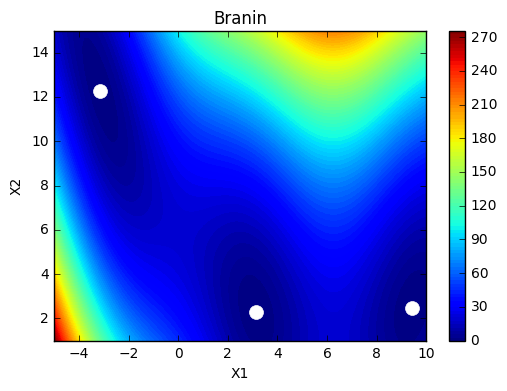

In [2]:
# --- Function to optimize
# Our experiment function:
# Input: Hyperparameter values
# Output: Accuracy
func  = GPyOpt.objective_examples.experiments2d.branin()
func.plot()

Because we are won't use the pre implemented wrapper, we need to create the classes for each element of the optimization. In total we need to create:

* Class for the **objective function (Experiment Team)**,
* Class for the **design space (Experiment Team)**,

In [3]:
# Reference: http://pythonhosted.org/GPyOpt/GPyOpt.core.task.html

# objective function: Wrapper over the Experiment function
objective = GPyOpt.core.task.SingleObjective(func.f)

# design space: Hyperparameter's domain
space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-5,10)},
                                    {'name': 'var_2', 'type': 'continuous', 'domain': (1,15)}])

* Class for the **model type (Model Team)**,

In [5]:
# Reference: http://pythonhosted.org/GPyOpt/GPyOpt.models.html

# The GP Accuracy model. GPyOpt.models.GPModel is a generic class for a GP model.
# http://pythonhosted.org/GPyOpt/GPyOpt.models.html#module-GPyOpt.models.gpmodel
K = GPy.kern.sde_Matern52
model = GPyOpt.models.GPModel(kernel=K,optimize_restarts=5,verbose=False)

* Class for the **cost type (Model Team)**,

In [21]:
# Reference: http://pythonhosted.org/GPyOpt/GPyOpt.core.task.html#GPyOpt.core.task.cost.CostModel

# The GP Cost model. Uses a generic GPModel
cost_model = GPyOpt.core.task.CostModel('evaluation_time')

* Class for the **acquisition optimizer (Model Team)**,

In [6]:
# Reference: http://pythonhosted.org/GPyOpt/GPyOpt.optimization.html
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

* Class for the **initial design (Model Team?)**,

In [7]:
# initial points
initial_design = GPyOpt.util.stats.initial_design('random', space, 5)

* Class for the **acquisition function**. Because we want to use our own acquisition, we need to implement a class to handle it. We will use the currently available Expected Improvement to create an integrated version over the jitter parameter. Samples will be generated using a beta distribution with parameters a and b as it is done using the default [numpy beta function](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.random.beta.html).

In [8]:
# Custom acquisition function built upon existing Acquisition functions
# AcquisitionBase: http://pythonhosted.org/GPyOpt/GPyOpt.acquisitions.html#module-GPyOpt.acquisitions.base
from GPyOpt.acquisitions.base import AcquisitionBase
from GPyOpt.acquisitions.EI import AcquisitionEI
from numpy.random import beta

class jitter_integrated_EI(AcquisitionBase):
    def __init__(self, model, space, optimizer=None, cost_withGradients=None, par_a=1, par_b=1, num_samples= 100):
        super(jitter_integrated_EI, self).__init__(model, space, optimizer)
        
        self.par_a = par_a
        self.par_b = par_b
        self.num_samples = num_samples
        self.samples = beta(self.par_a,self.par_b,self.num_samples)
        self.EI = AcquisitionEI(model, space, optimizer, cost_withGradients)
    
    def acquisition_function(self,x):
        acqu_x = np.zeros((x.shape[0],1))       
        for k in range(self.num_samples):
            self.EI.jitter = self.samples[k]
            acqu_x +=self.EI.acquisition_function(x)           
        return acqu_x/self.num_samples
    
    def acquisition_function_withGradients(self,x):
        acqu_x      = np.zeros((x.shape[0],1))       
        acqu_x_grad = np.zeros(x.shape)
        
        for k in range(self.num_samples):
            self.EI.jitter = self.samples[k]       
            acqu_x_sample, acqu_x_grad_sample =self.EI.acquisition_function_withGradients(x) 
            acqu_x += acqu_x_sample
            acqu_x_grad += acqu_x_grad_sample           
        return acqu_x/self.num_samples, acqu_x_grad/self.num_samples

Now we initialize the class for this acquisition and we plot the histogram of the used samples to integrate the acquisition.

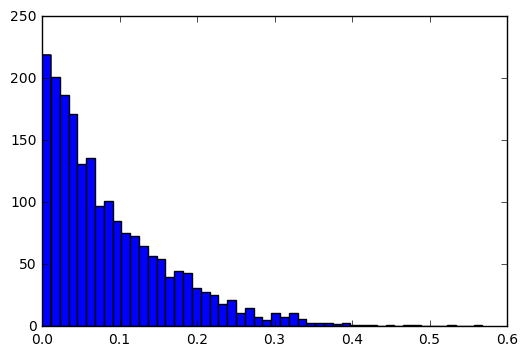

In [18]:
acquisition = jitter_integrated_EI(model, space, optimizer=aquisition_optimizer, par_a=1, par_b=10, num_samples=2000)
xx = plt.hist(acquisition.samples,bins=50)

* Finally we create the class for the **type of evaluator**,

In [22]:
# --- CHOOSE a collection method
# Reference: http://pythonhosted.org/GPyOpt/GPyOpt.core.evaluators.html
# Wrapper over the acquisition function.
# Allows batch/nonmyopic acquisition if we use GPyOpt.core.evaluators.batch_predictive.
# We can write our own batch criterion by extending EvaluatorBase and write our own .compute_batch()
# Refer to http://pythonhosted.org/GPyOpt/_modules/GPyOpt/core/evaluators/batch_predictive.html
#   for batch evaluation 
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

With all the classes on place,including the one we have created for this example, we can now create the **Bayesian optimization object**. **(Just need someone to run)**

In [23]:
# References:
#  http://pythonhosted.org/GPyOpt/GPyOpt.methods.html#module-GPyOpt.methods.modular_bayesian_optimization
#  http://pythonhosted.org/GPyOpt/_modules/GPyOpt/methods/modular_bayesian_optimization.html#ModularBayesianOptimization

# Here is where we put everything together
# model: Accuracy GP model
# space: hyperparameter domain
# objective: Model function to optimize
# acquisition: criterion
# evaluator: 
# initial design: initial points
# cost: time GP model

bo = GPyOpt.methods.ModularBayesianOptimization(model=model,
                                                space=space,
                                                objective=objective,
                                                acquisition=acquisition,
                                                evaluator=evaluator,
                                                X_init=initial_design,
                                                cost=cost_model)

And we run the optimization.

In [24]:
max_iter  = 10                                            
bo.run_optimization(max_iter = max_iter)

We plot the acquisition and the diagnostic plots. **(Model Team)**

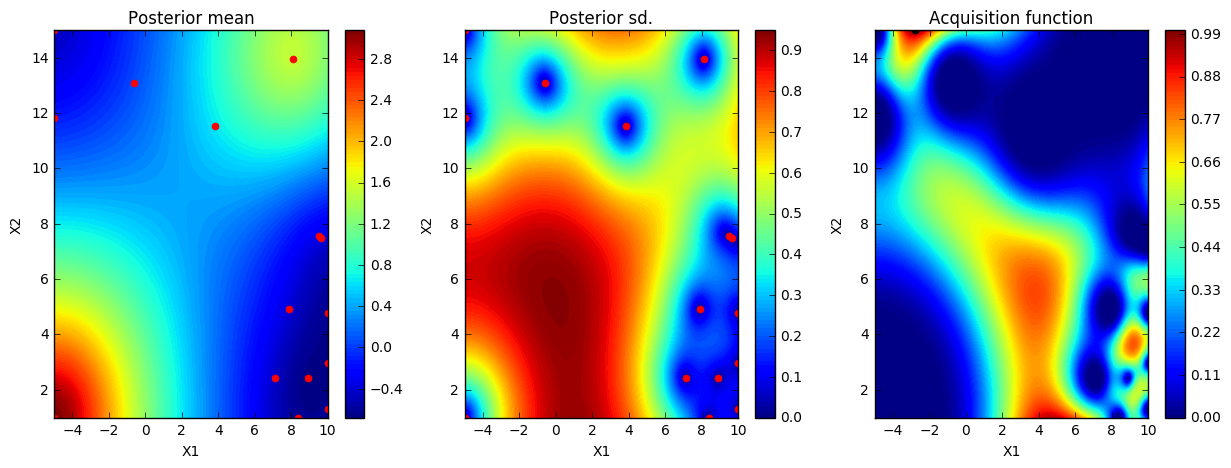

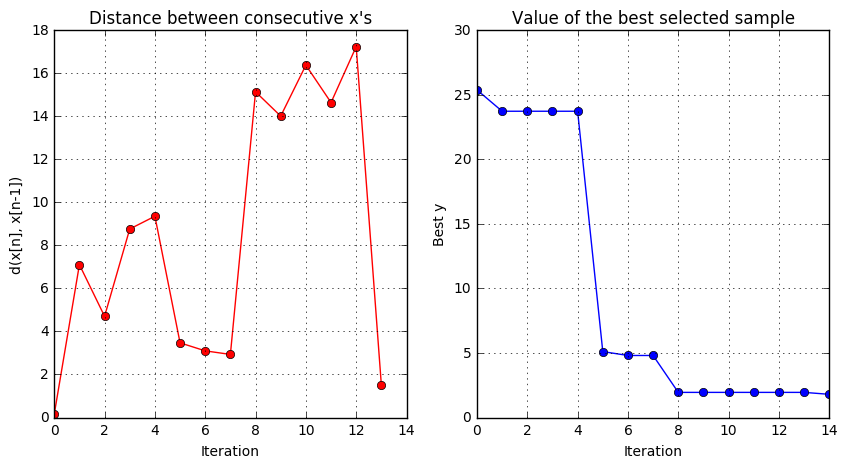

In [25]:
bo.plot_acquisition()
bo.plot_convergence()